In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors, KNeighborsTransformer
pd.set_option('display.max_columns', None)

In [13]:
import os

# User selections
# List to store DataFrames for each user
user_choices = []

# Get all files from the user_output directory
user_files = os.listdir("../../data/user_output/")

# Read each file into a DataFrame and add to the list
for file in user_files:
    file_path = os.path.join("../../data/user_output/", file)
    user_df = pd.read_csv(file_path)
    user_choices.append(user_df)

df_pueblos = pd.read_csv("../../data/interim/pueblos_recommender.csv")


In [14]:
df_pueblos

,cmun,province,municipality,altitude,longitude,latitude,0-17,18-24,25-34,35-54,55+,male,female,total_population,nearest_airport,closest_distance_airport,nearest_train_station,closest_distance_train,closest_distance_hospital,nearest_hospital,closest_distance_school,nearest_school,koppen_climate,description,number_of_houses,town_size,connectivity_score,connectivity_category,towns_in_vicinity,economy_score,economy_score_area,autonomous_community,hospital_distance_score,school_distance_score,hospital_score_area,school_score_area,train_distance_score,airport_distance_score,transport_score,0-17_pct,18-24_pct,25-34_pct,35-54_pct,55+_pct,age_score,final_age_category,PC1,PC2,PC3,PC4,PC5,cluster,enc_scaled__female,enc_scaled__total_population,enc_scaled__number_of_houses,enc_scaled__connectivity_score,enc_scaled__economy_score,enc_scaled__economy_score_area,enc_scaled__hospital_distance_score,enc_scaled__school_distance_score,enc_scaled__hospital_score_area,enc_scaled__school_score_area,enc_scaled__train_distance_score,enc_scaled__airport_distance_score,enc_scaled__transport_score,enc_scaled__age_score
0,48067,Bizkaia,Muxika,18.95764,-2.692941,43.28967,302,96,101,463,584,810,736,1546,Aeropuerto de Bilbao,17.538797,Vitoria/Gasteiz,49.813235,12.530042,Hospital Galdakao-Usansolo,0.288898,Urretxindorra Hlhi,Cfb,Oceanic Climate - Mild temperatures and consis...,784.0,Mid,0.7180,Good,"1002, 1003, 1004, 1010, 1018, 1036, 1042, 1054...",4.10,16.823071,País Vasco,6,10,3.0,5.0,1,6,3.5,19.534282,6.209573,6.532988,29.948254,37.774903,17.302717,Balanced Town,2.164926,0.182832,0.818498,1.144715,1.545604,0,0.579622,0.621053,0.197205,0.244789,0.492637,1.268902,1.018151,0.692736,1.018151,0.692736,-1.074248,1.461643,-0.237222,0.768669
1,33038,Asturias,Morcín,236.84730,-5.883333,43.28333,273,154,182,730,1197,1281,1255,2536,Aeropuerto de Asturias,33.257297,Linares-Congostinas,22.103683,6.481795,Centro Médico De Asturias,0.471700,E.E.I. Monsacro,Csb,"Mediterranean Warm Summer - Cooler, wet winter...",1992.0,Mid,0.3095,Weak,"24145, 24164, 33002, 33005, 33032, 33033, 3303...",6.35,12.380000,Asturias,8,10,4.0,5.0,3,4,3.5,10.764984,6.072555,7.176656,28.785489,47.200315,-1.813880,Highly Aging Town,3.104454,-0.640464,0.272644,1.103487,1.420369,0,1.478051,1.472676,1.780817,-1.099361,0.972821,0.738659,1.781115,0.692736,1.781115,0.692736,-0.434918,0.266492,-0.237222,0.150066
2,39045,Cantabria,Miera,338.03460,-3.711944,43.27555,44,10,30,117,199,212,188,400,Santander-Seve Ballesteros,18.992934,Quintanilla De Las Torres,64.587560,22.196918,Hospital Universitario Marqués De Valdecilla,2.417149,Escuela Pública de Mirones,Cfb,Oceanic Climate - Mild temperatures and consis...,281.0,Small,0.1485,Poor,"9025, 9124, 9189, 9214, 9215, 9216, 9410, 9413...",0.00,1.608974,Cantabria,3,10,1.5,5.0,1,6,3.5,11.000000,2.500000,7.500000,29.250000,49.750000,-7.750000,Highly Aging Town,-0.781202,0.760289,0.945299,-0.358224,2.246560,1,-0.369009,-0.364765,-0.462196,-1.629125,-0.382365,-0.546772,-0.126296,0.692736,-0.126296,0.692736,-1.074248,1.461643,-0.237222,-0.042023
3,33001,Asturias,Allande,580.72880,-6.616667,43.26667,104,52,117,352,906,767,764,1531,Aeropuerto de Asturias,57.580592,Linares-Congostinas,71.059836,11.611705,Hospital Carmen Y Severo Ochoa,1.217263,C.P.E.B. Pola de Allande,Cfb,Oceanic Climate - Mild temperatures and consis...,1680.0,Mid,0.3235,Weak,"27018, 27035, 33005, 33011, 33022, 33027, 3302...",4.25,5.077273,Asturias,6,10,3.0,5.0,1,3,2.0,6.792946,3.396473,7.642064,22.991509,59.177008,-32.201176,Highly Aging Town,0.930247,-0.968618,1.142487,0.826264,1.166742,0,0.628092,0.608150,1.371804,-1.053295,0.524650,-0.132860,1.018151,0.692736,1.018151,0.692736,-1.074248,-0.331083,-1.015349,-0.833250
4,33061,Asturias,San Martín de Oscos,701.40340,-6.961694,43.26435,27,16,11,85,197,164,172,336,Aeropuerto de Asturias,82.202004,Lugo,55.447374,35.090964,Hospital Carmen Y Severo Ochoa,4.683508,C.R.A. Oscos,Cfb,Oceanic Climate - Mild temperatures and consis...,362.0,Small,0.3225,Weak,"27

In [15]:
from scipy.stats import pearsonr

# Filter encoded features from pueblos data
df_pueblos_enc = df_pueblos.filter(regex=r"^enc_", axis=1)

# Select only numerical features with more than 2 unique values (non-binary features)
pueblos_numerical_features = df_pueblos_enc.loc[:, (df_pueblos_enc.nunique() > 2)]

# select 1 user from our data
selected_villages = user_choices[0]

display(selected_villages)
df_selected_enc = selected_villages.filter(regex=r"^enc_", axis=1)
selected_numerical_features = df_selected_enc.loc[:, ~(df_selected_enc.isin([0.0, 1.0]).all())]

display(selected_numerical_features)

# Compute the selection profile as the mean of the selected villages
selection_profile = selected_numerical_features.mean()

display(selection_profile)

# Calculate Pearson correlation with each village
correlation_scores = []
for idx, row in pueblos_numerical_features.iterrows():
    # Extract only the columns that exist in both dataframes
    common_columns = list(set(selection_profile.index) & set(row.index))
    
    if len(common_columns) > 1:  # Need at least 2 points for correlation
        correlation, _ = pearsonr(selection_profile[common_columns], row[common_columns])
    else:
        correlation = 0  # Default if not enough common columns
        
    correlation_scores.append(correlation)

# Add the correlation scores to the DataFrame
df_pueblos['pearson_correlation'] = correlation_scores

# Show the top 10 most similar villages
top_villages = df_pueblos.nlargest(5, 'pearson_correlation')
print(top_villages[['municipality', 'province', 'pearson_correlation']])

,cmun,province,municipality,altitude,longitude,latitude,0-17,18-24,25-34,35-54,55+,male,female,total_population,nearest_airport,closest_distance_airport,nearest_train_station,closest_distance_train,closest_distance_hospital,nearest_hospital,closest_distance_school,nearest_school,koppen_climate,description,number_of_houses,town_size,connectivity_score,connectivity_category,towns_in_vicinity,economy_score,economy_score_area,autonomous_community,hospital_distance_score,school_distance_score,hospital_score_area,school_score_area,train_distance_score,airport_distance_score,transport_score,0-17_pct,18-24_pct,25-34_pct,35-54_pct,55+_pct,age_score,final_age_category,PC1,PC2,PC3,PC4,PC5,cluster,enc_scaled__total_population,enc_scaled__economy_score,enc_scaled__economy_score_area,enc_scaled__hospital_score_area,enc_scaled__school_score_area,enc_scaled__transport_score,enc_scaled__female,enc_scaled__connectivity_score,enc_scaled__number_of_houses,enc_scaled__hospital_distance_score,enc_scaled__school_distance_score,enc_scaled__train_distance_score,enc_scaled__airport_distance_score,enc_scaled__age_score
0,47161,Valladolid,Simancas,715.7623,-4.826713,41.59023,1107,559,459,1594,1832,2807,2744,5551,Aeropuerto de Valladolid,13.315067,Viana,9.499200,10.159652,Hospital Campo Grande,0.239856,Escuela De Música De Simancas,Csa,"Mediterranean Hot Summer - Hot, dry summers an...",2603.0,Big,0.9560,Excellent,"34010, 34066, 34069, 34106, 34240, 40124, 4016...",40.60,24.104746,Castilla y León,6,10,3.0,5.0,8,8,8.0,19.942353,10.070258,8.268780,28.715547,33.003063,30.147721,Young & Growing,8.797828,-2.307241,-2.570954,-1.592296,-1.853139,3,3.737580,7.366698,2.022572,1.062733,0.721064,2.110809,3.724344,0.996581,2.447766,1.062733,0.721064,1.213709,2.598132,1.156940
1,21058,Huelva,Puebla de Guzmán,212.8246,-7.245831,37.61144,490,217,340,919,1165,1600,1531,3131,Aeropuerto de Sevilla,120.986752,El Cobujon,27.899376,39.362097,Hospital Virgen De La Bella,0.731641,C.E.I.P. Sebastián García Vázquez,Csa,"Mediterranean Hot Summer - Hot, dry summers an...",1696.0,Big,0.8120,Excellent,"21003, 21006, 21015, 21017, 21021, 21023, 2103...",4.40,9.185294,Andalucía,1,10,0.5,5.0,2,1,1.5,15.649952,6.930693,10.859150,29.351645,37.208560,24.688598,Balanced Town,1.529577,-2.988063,1.423782,-0.833459,0.816148,4,1.794093,0.444280,0.308476,-0.883675,0.721064,-1.246276,1.765976,0.529640,1.298609,-0.883675,0.721064,-0.729741,-1.510202,0.984047
2,13054,Ciudad Real,Membrilla,667.7634,-3.348246,38.97219,926,410,633,1516,2350,2909,2926,5835,Aeropuerto de Albacete,128.741028,Manzanares,4.203689,3.219899,Hospital Virgen De Altagracia,3.925121,C.P. Altagracia,BSk,"Cold Semi-Arid Climate - Dry, but with lower t...",3156.0,Big,0.9030,Excellent,"13008, 13010, 13013, 13018, 13019, 13023, 1303...",21.35,27.862500,Castilla-La Mancha,10,10,5.0,5.0,10,1,5.5,15.869751,7.026564,10.848329,25.981148,40.274207,15.218509,Balanced Town,7.995257,-2.414147,-1.299899,0.818991,0.271437,3,3.965659,3.685578,2.454301,2.619860,0.721064,0.819623,4.018180,0.824720,3.148409,2.619860,0.721064,1.861526,-1.510202,0.684126
3,45096,Toledo,Mazarambroz,778.5905,-4.021279,39.69421,207,99,141,335,503,666,619,1285,Aeropuerto de Madrid - Cuatro vientos,77.764316,Toledo,18.690216,18.562296,Hospital Provincial Nuestra Señora De La Miser...,12.262318,CEIP Cardenal Tavera,Csa,"Mediterranean Hot Summer - Hot, dry summers an...",880.0,Mid,0.8525,Excellent,"45001, 45003, 45012, 45014, 45016, 45018, 4501...",4.55,10.787079,Castilla-La Mancha,4,6,2.0,3.0,4,3,3.5,16.108949,7.704280,10.972763,26.070039,39.143969,18.093385,Balanced Town,0.438305,-1.018110,-1.217268,1.256293,0.750380,3,0.311583,0.472964,0.492505,0.284170,-1.242798,-0.213326,0.293568,0.660967,0.264749,0.284170,-1.242798,-0.081924,-0.336392,0.775174
4,5246,Ávila,Tórtoles,1242.6980,-5.261655,40.56090,1,1,4,3,29,22,16,38,Aeropuerto de Salamanca,47.848847,Peñaranda De Bracamonte,37.727499,49.165837,Hospital Provincial De Ávila,12.298327,Gran Duque De Alba,Csb,"Mediterranean Wa

,enc_scaled__total_population,enc_scaled__economy_score,enc_scaled__economy_score_area,enc_scaled__hospital_score_area,enc_scaled__school_score_area,enc_scaled__transport_score,enc_scaled__female,enc_scaled__connectivity_score,enc_scaled__number_of_houses,enc_scaled__hospital_distance_score,enc_scaled__school_distance_score,enc_scaled__train_distance_score,enc_scaled__airport_distance_score,enc_scaled__age_score
0,3.737580,7.366698,2.022572,1.062733,0.721064,2.110809,3.724344,0.996581,2.447766,1.062733,0.721064,1.213709,2.598132,1.156940
1,1.794093,0.444280,0.308476,-0.883675,0.721064,-1.246276,1.765976,0.529640,1.298609,-0.883675,0.721064,-0.729741,-1.510202,0.984047
2,3.965659,3.685578,2.454301,2.619860,0.721064,0.819623,4.018180,0.824720,3.148409,2.619860,0.721064,1.861526,-1.510202,0.684126
3,0.311583,0.472964,0.492505,0.284170,-1.242798,-0.213326,0.293568,0.660967,0.264749,0.284170,-1.242798,-0.081924,-0.336392,0.775174
4,-0.689875,-0.397119,-0.703959,-0.883675,-1.242798,-0.729801,-0.679965,1.048463,-0.625943,-0.883675,-1.242798,-1.053649,0.250512,-2.256471


enc_scaled__total_population           1.823808
enc_scaled__economy_score              2.314480
enc_scaled__economy_score_area         0.914779
enc_scaled__hospital_score_area        0.439883
enc_scaled__school_score_area         -0.064481
enc_scaled__transport_score            0.148206
enc_scaled__female                     1.824420
enc_scaled__connectivity_score         0.812074
enc_scaled__number_of_houses           1.306718
enc_scaled__hospital_distance_score    0.439883
enc_scaled__school_distance_score     -0.064481
enc_scaled__train_distance_score       0.241984
enc_scaled__airport_distance_score    -0.101630
enc_scaled__age_score                  0.268763
dtype: float64

     municipality   province  pearson_correlation
873     Sénia, La  Tarragona             0.938604
311      Celanova    Ourense             0.919060
1018      Borriol  Castellón             0.919008
1045        Yepes     Toledo             0.917039
1279      Pedrera    Sevilla             0.908136


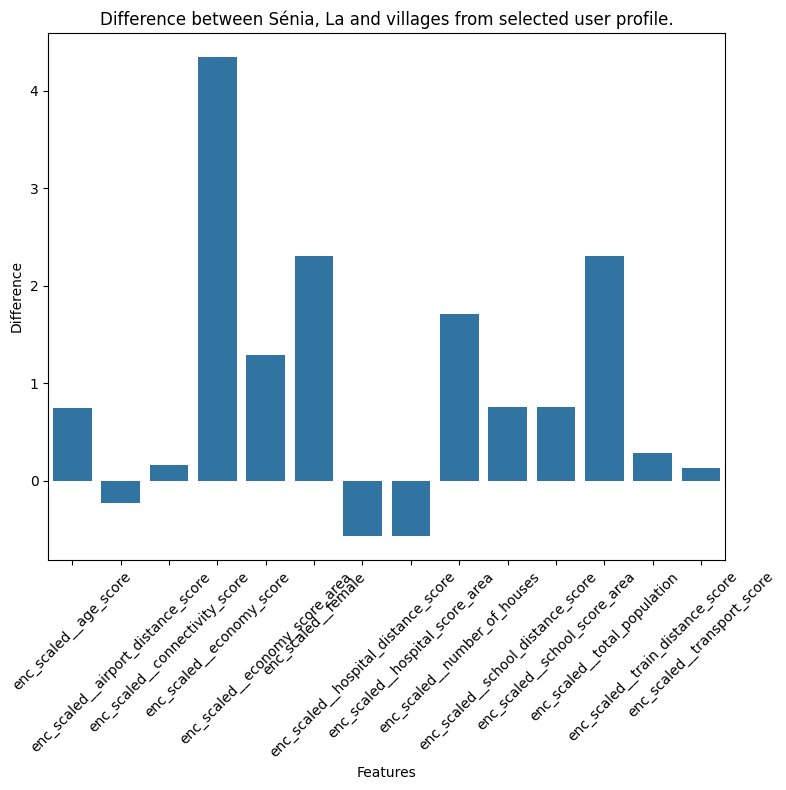

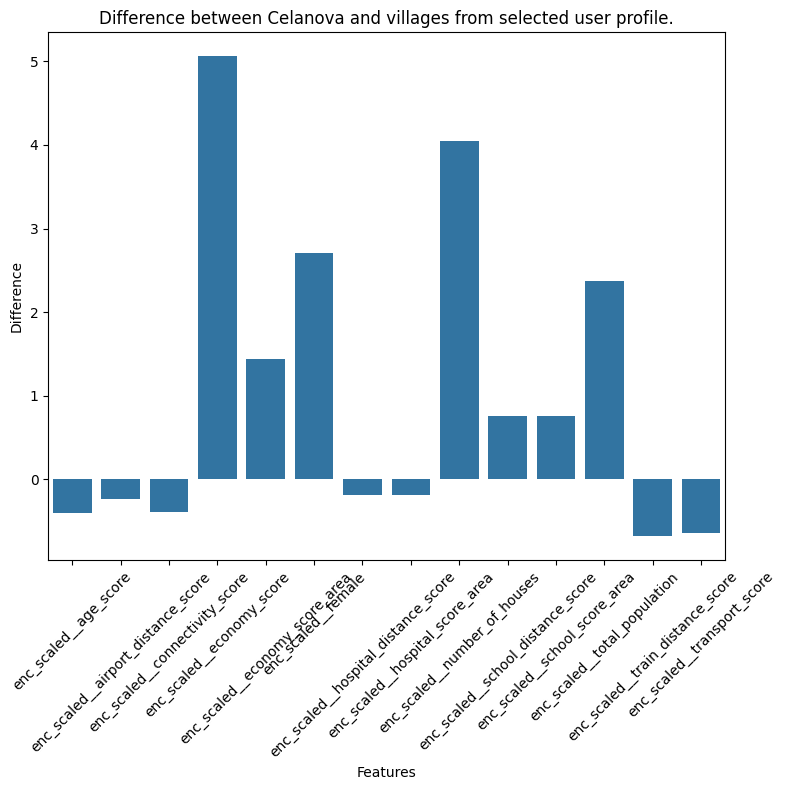

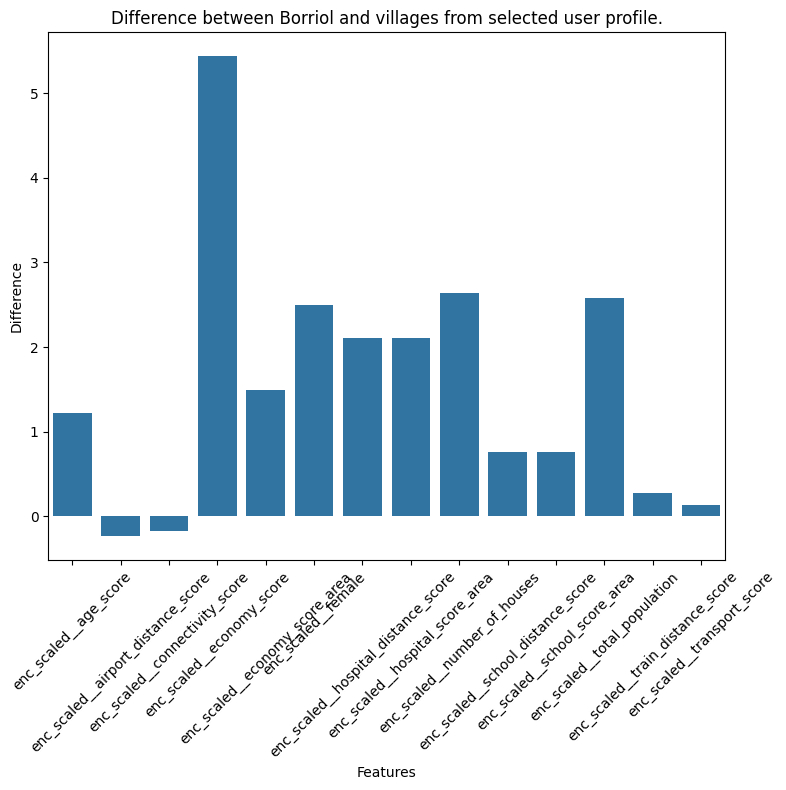

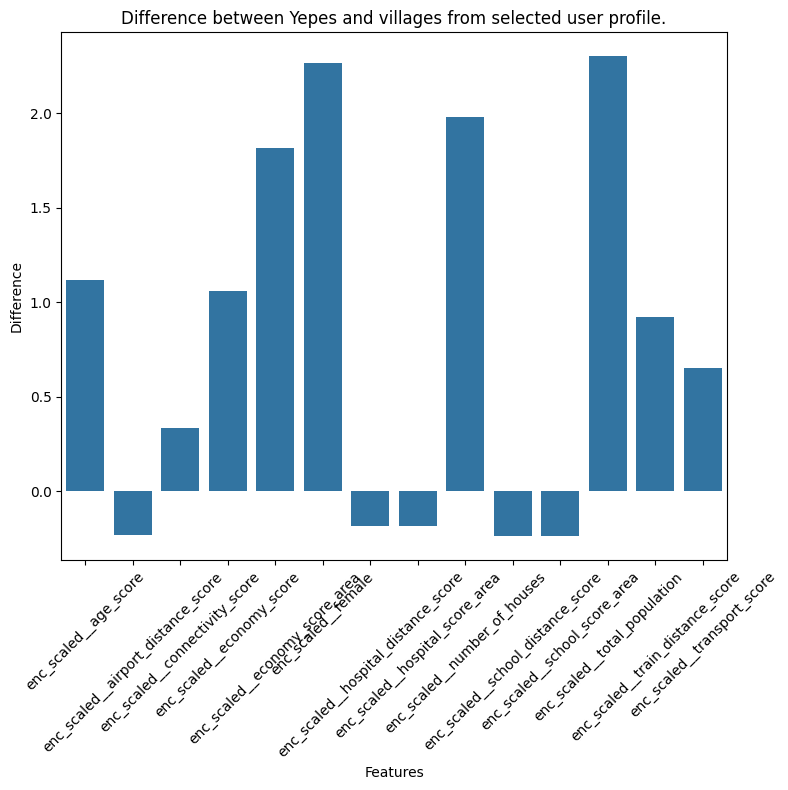

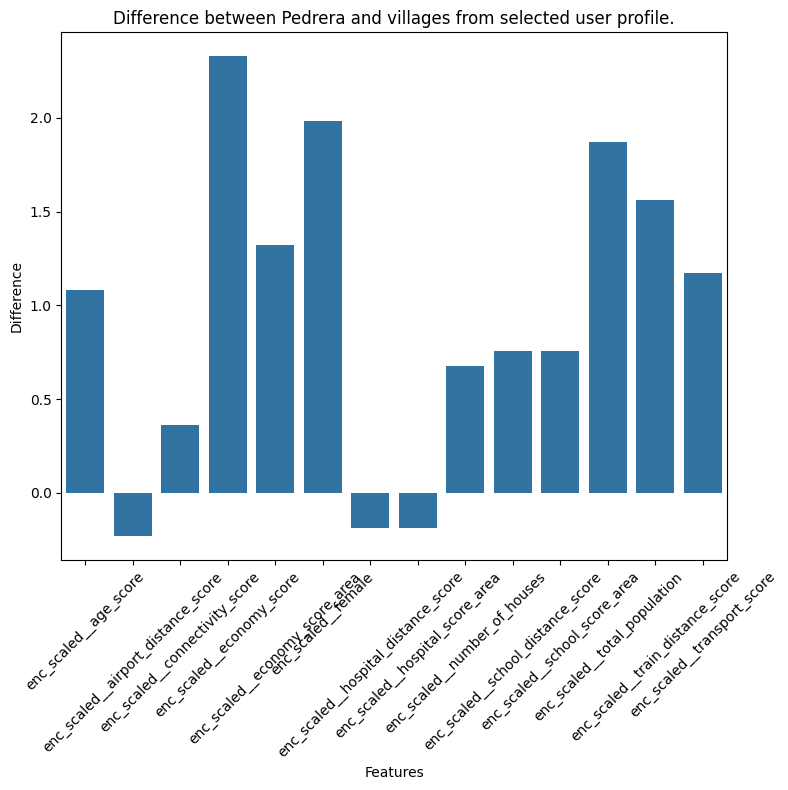

In [21]:
import seaborn as sns

# Select the specific village data
top_villages_data = df_pueblos.loc[top_villages.index, pueblos_numerical_features.columns]

# Calculate the mean of the selected columns for the selected villages
mean_values = selection_profile

# Loop through the available rows in top_villages_data
for i in range(len(top_villages_data)):
    # Calculate the difference between the mean values and the specific village data
    difference = top_villages_data.iloc[i] - mean_values

    # Create a DataFrame for the differences
    difference_df = pd.DataFrame(difference, columns=['Difference'])

    # Plot the differences
    plt.figure(figsize=(8, 8))
    sns.barplot(x=difference_df.index, y='Difference', data=difference_df)
    plt.title(f'Difference between {top_villages.iloc[i]["municipality"]} and villages from selected user profile.')
    plt.xlabel('Features')
    plt.ylabel('Difference')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Index(['cmun', 'province', 'municipality', 'altitude', 'longitude', 'latitude',
       '0-17', '18-24', '25-34', '35-54', '55+', 'male', 'female',
       'total_population', 'nearest_airport', 'closest_distance_airport',
       'nearest_train_station', 'closest_distance_train',
       'closest_distance_hospital', 'nearest_hospital',
       'closest_distance_school', 'nearest_school', 'koppen_climate',
       'description', 'number_of_houses', 'town_size', 'connectivity_score',
       'connectivity_category', 'towns_in_vicinity', 'economy_score',
       'economy_score_area', 'autonomous_community', 'hospital_distance_score',
       'school_distance_score', 'hospital_score_area', 'school_score_area',
       'train_distance_score', 'airport_distance_score', 'transport_score',
       '0-17_pct', '18-24_pct', '25-34_pct', '35-54_pct', '55+_pct',
       'age_score', 'final_age_category', 'cluster', 'pearson_correlation'],
      dtype='object')

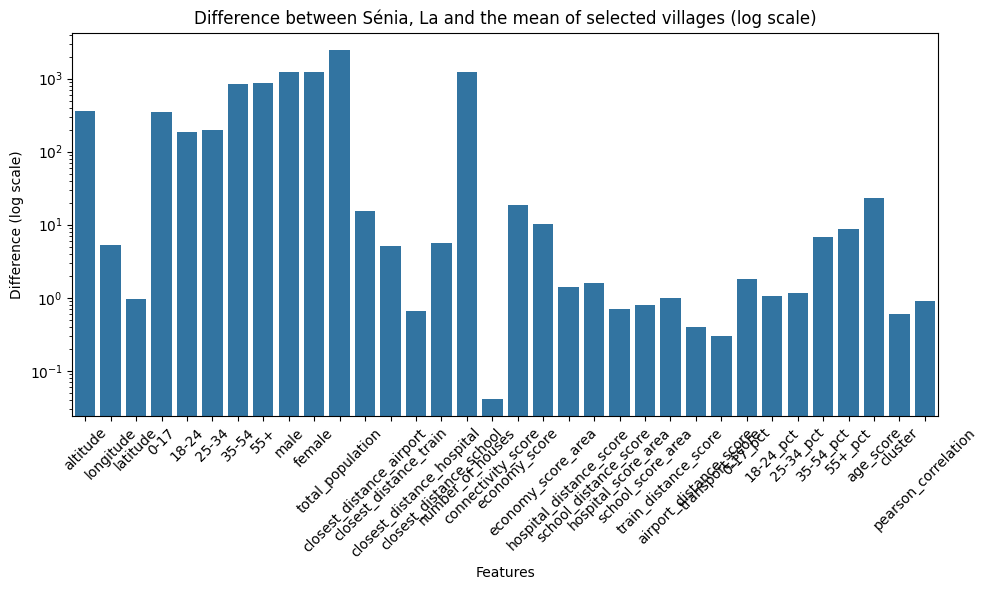

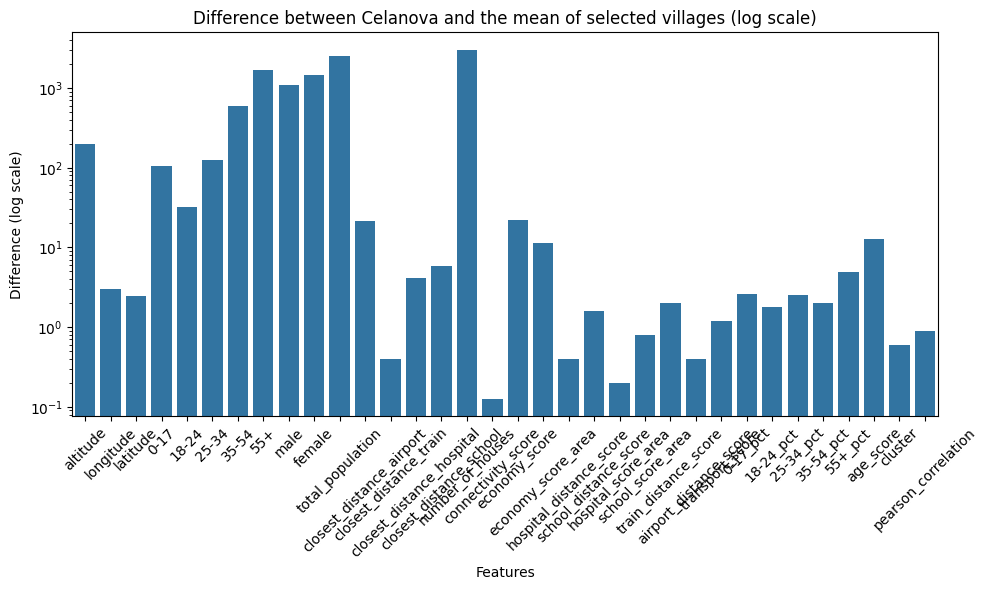

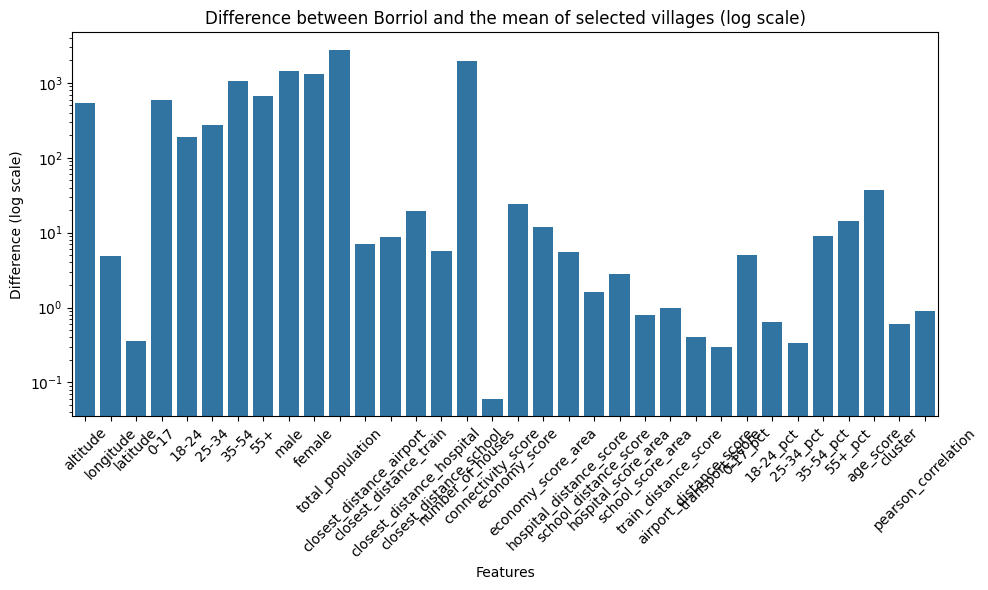

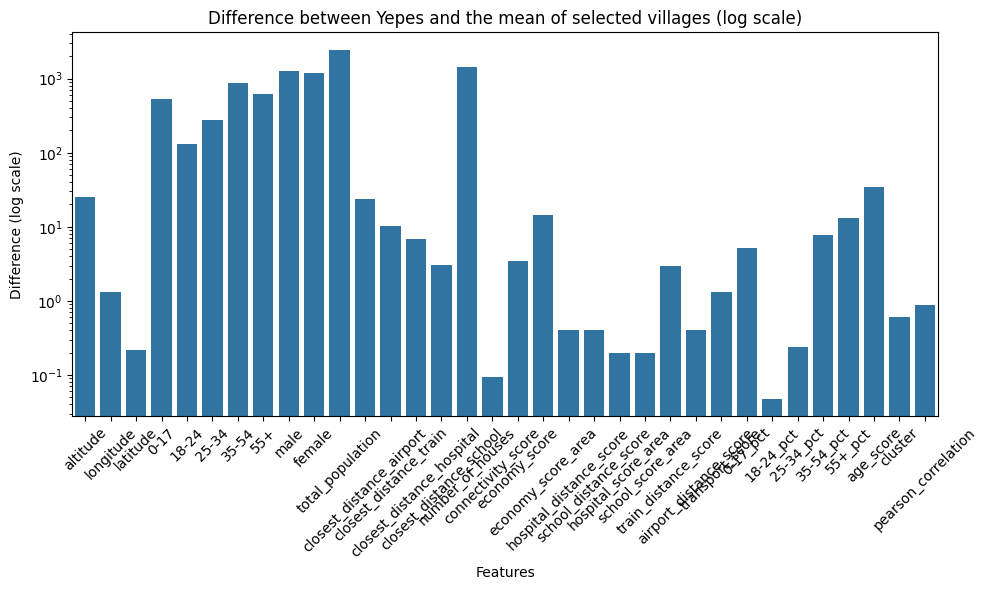

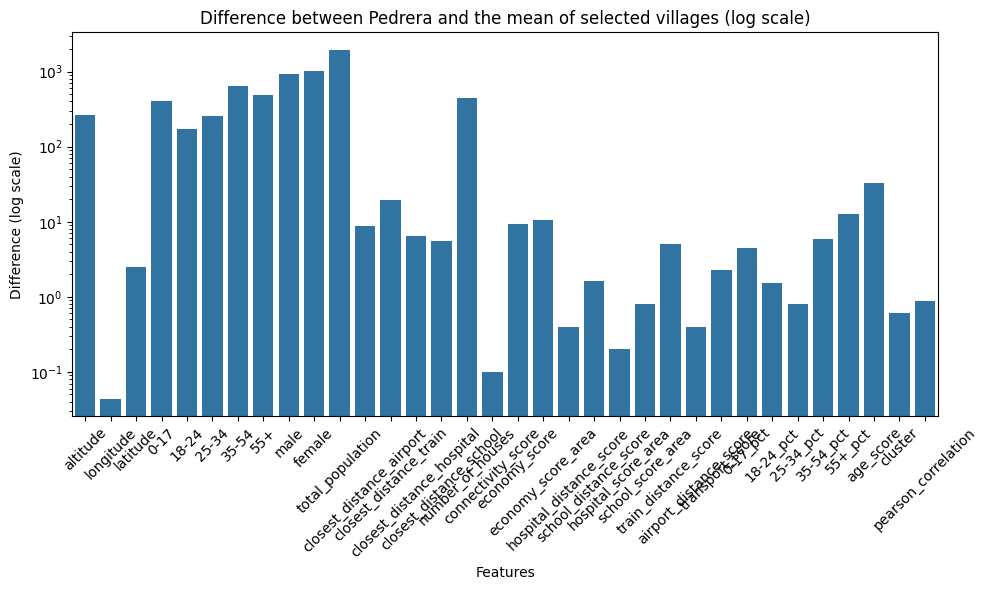

In [ ]:
# Ensure 'pearson_correlation' column is present in top_villages
if 'pearson_correlation' not in top_villages.columns:
    top_villages = top_villages.join(df_pueblos['pearson_correlation'], how='left', rsuffix='_pueblos')

if 'pearson_correlation' not in selected_villages.columns:
    selected_villages = selected_villages.join(df_pueblos['pearson_correlation'], how='left', rsuffix='_pueblos')

# Filter out columns starting with 'enc_'
numerical_columns = top_villages.columns[~top_villages.columns.str.startswith('enc_') & ~top_villages.columns.str.startswith('PC')]


display(numerical_columns)

# Select only numerical columns
top_villages_numerical = top_villages[numerical_columns].select_dtypes(include=[np.number])
selected_villages_numerical = selected_villages[numerical_columns].select_dtypes(include=[np.number])

top_villages_numerical.drop(['cmun'], axis=1, inplace=True)
selected_villages_numerical.drop(['cmun'], axis=1, inplace=True)

# Calculate the mean of the selected villages
selected_villages_mean = selected_villages_numerical.mean()

# Loop through the top villages and plot the differences
for i in range(len(top_villages_numerical)):
    # Calculate the difference between the mean values and the specific village data
    difference = abs(top_villages_numerical.iloc[i] - selected_villages_mean)
    
    # Add small epsilon to avoid log(0) issues
    difference = difference.replace(0, 1e-10)
    
    # Create a DataFrame for the differences
    difference_df = pd.DataFrame(difference, columns=['Difference'])

    # Plot the differences with logarithmic scale
    plt.figure(figsize=(10, 6))
    sns.barplot(x=difference_df.index, y='Difference', data=difference_df)
    plt.yscale('log')  # Set logarithmic scale for y-axis
    plt.title(f'Difference between {top_villages.iloc[i]["municipality"]} and the mean of selected villages (log scale)')
    plt.xlabel('Features')
    plt.ylabel('Difference (log scale)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

### Explained Variance ($r^2$):
Since Pearson correlation gives us 
𝑟, we can square it to get the explained variance.
This tells us how much of the variance in a village's features is explained by the selection profile.

In [10]:
# Calculate Explained Variance
df_pueblos['explained_variance'] = df_pueblos['pearson_correlation'] ** 2

# Show top villages with explained variance
top_villages = df_pueblos.nlargest(5, 'explained_variance')
top_villages[['municipality', 'province', 'explained_variance']]


,municipality,province,explained_variance
873,"Sénia, La",Tarragona,0.880977
311,Celanova,Ourense,0.844671
1018,Borriol,Castellón,0.844576
1045,Yepes,Toledo,0.840960
1279,Pedrera,Sevilla,0.824711


In [ ]:
# from scipy.stats import spearmanr

# # Calculate Spearman correlation between predicted and true scores
# spearman_corr, _ = spearmanr(true_scores, df_pueblos['pearson_correlation'])
# print(f"Spearman Rank Correlation: {spearman_corr:.4f}")

NameError: name 'true_scores' is not defined